<a href="https://colab.research.google.com/github/NotAbdelrahmanelsayed/energy-consumption-forcasting/blob/main/Copy_of_weather_forcasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!git clone https://github.com/NotAbdelrahmanelsayed/energy-consumption-forcasting.git

Cloning into 'energy-consumption-forcasting'...
remote: Enumerating objects: 28, done.
remote: Counting objects: 100% (28/28), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 28 (delta 3), reused 23 (delta 1), pack-reused 0
Receiving objects: 100% (28/28), 2.70 MiB | 33.29 MiB/s, done.
Resolving deltas: 100% (3/3), done.


In [4]:
%cd energy-consumption-forcasting
!mkdir results

[Errno 2] No such file or directory: 'energy-consumption-forcasting'
/content/energy-consumption-forcasting


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.metrics import mean_squared_error

tf.random.set_seed(42) # Fix random seed for reproducibility.

# Function to create sequences
def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length])
        y.append(data[i+sequence_length])
    return np.array(X), np.array(y)

# Function to build the model
def build_model(input_shape, lstm_units=150, dropout_rate=0.1, bidirectional=True):
    model = Sequential()
    if bidirectional:
        model.add(Bidirectional(LSTM(lstm_units, return_sequences=True), input_shape=input_shape))
    else:
        model.add(LSTM(lstm_units, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(dropout_rate))
    if bidirectional:
        model.add(Bidirectional(LSTM(lstm_units, return_sequences=False)))
    else:
        model.add(LSTM(lstm_units, return_sequences=False))
    model.add(Dropout(dropout_rate))
    model.add(Dense(4))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Read the dataset
df = pd.read_csv('data/Alexandria - Weather Data.csv')

# Rename features for consistency
renamed_features = {
    'Date ': 'date',
    'Ambient Temperature': 'ambient_temperature',
    'wind_speed_10m (km/h)': 'wind_speed_10m_kmh',
    'wind_speed_100m (km/h)': 'wind_speed_100m_kmh',
    'Solar Radiation': 'solar_radiation'
}
df.rename(columns=renamed_features, inplace=True)
df.dropna(axis=0, inplace=True)

# Convert date to datetime and set it as the index
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

# Convert the dataset into numpy array
data = np.array(df)

# Best hyperparameters from Optuna
best_params = {
    'sequence_length': 3*24,
    'lstm_units': 100,
    'dropout_rate': 0.1,
    'bidirectional': True,
    'scaler': 'MinMaxScaler'
}

if best_params['scaler'] == 'MinMaxScaler':
    scaler = MinMaxScaler()
elif best_params['scaler'] == 'StandardScaler':
    scaler = StandardScaler()
else:
    scaler = RobustScaler()

scaled_data = scaler.fit_transform(data)

# Split into training and testing data
train_size = int(len(df) * 0.8)
train_data, test_data = scaled_data[:train_size], scaled_data[train_size:]

# Create sequences
X_train, y_train = create_sequences(train_data, best_params['sequence_length'])
X_test, y_test = create_sequences(test_data, best_params['sequence_length'])

model = build_model((best_params['sequence_length'], 4),
                    best_params['lstm_units'],
                    best_params['dropout_rate'],
                    best_params['bidirectional'])

# Add EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=100, batch_size=512,
                    validation_split=0.2, verbose=1, callbacks=[early_stopping])

# Make predictions
predictions = model.predict(X_test)

# Inverse scale the predictions
predicted_values = scaler.inverse_transform(predictions)
actual_values = scaler.inverse_transform(y_test)

# Clip negative values to zero
predicted_values = np.clip(predicted_values, a_min=0, a_max=None)

# Compare predictions with actual values
comparison = pd.DataFrame({
    'Actual Temperature': actual_values[:, 0],
    'Predicted Temperature': predicted_values[:, 0],
    'Actual Wind Speed 10m': actual_values[:, 1],
    'Predicted Wind Speed 10m': predicted_values[:, 1],
    'Actual Wind Speed 100m': actual_values[:, 2],
    'Predicted Wind Speed 100m': predicted_values[:, 2],
    'Actual Solar Radiation': actual_values[:, 3],
    'Predicted Solar Radiation': predicted_values[:, 3],
})

# Plot predictions vs. actual values for each feature
fig, axes = plt.subplots(4, 1, figsize=(14, 24))
for ax, (actual, predicted, title) in zip(axes, [
    ('Actual Temperature', 'Predicted Temperature', 'Temperature'),
    ('Actual Wind Speed 10m', 'Predicted Wind Speed 10m', 'Wind Speed 10m'),
    ('Actual Wind Speed 100m', 'Predicted Wind Speed 100m', 'Wind Speed 100m'),
    ('Actual Solar Radiation', 'Predicted Solar Radiation', 'Solar Radiation')
]):
    ax.plot(comparison[actual], label=actual)
    ax.plot(comparison[predicted], label=predicted)
    ax.set_title(f'{title}: Actual vs. Predicted')
    ax.set_xlabel('Time Steps')
    ax.set_ylabel(title)
    ax.legend()
plt.show()

This code imports essential libraries for a machine learning project involving LSTM neural networks for time series forecasting.

In [1]:
%cd energy-consumption-forcasting

/content/energy-consumption-forcasting


**prepare the dataset**

# 3. **Model Training**:
   - Define and compile the LSTM model.
   - Train the model on the training data.

# 4. **Evaluation**:
   - Evaluate the model on the test data.
   - Plot the training and validation loss.
   - Make predictions on the test set.
   - Inverse scale the predictions and compare them with actual values.
   - Visualize the predictions vs. actual values for each feature.


In [36]:
# Evaluate the model
loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss:.4f}')
print('RMSE: ', np.sqrt(loss))

788/788 [==============================] - 7s 9ms/step - loss: 0.0011
Test Loss: 0.0011
RMSE:  0.032797406761352906


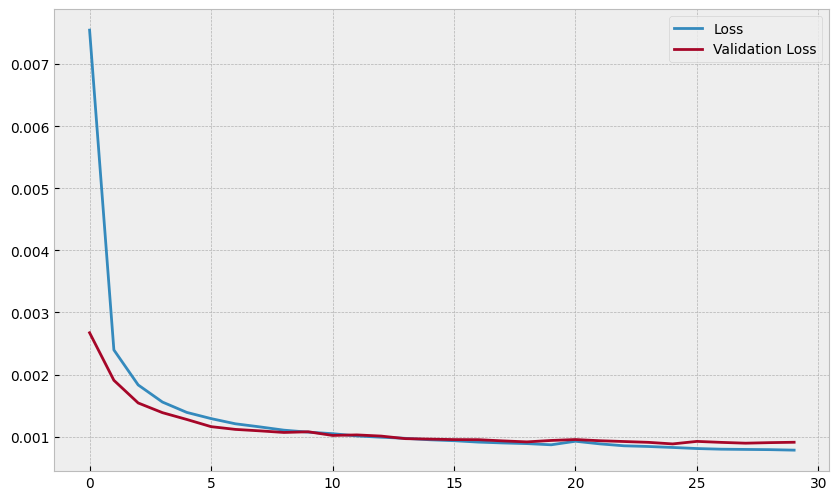

In [37]:
# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Loss', 'Validation Loss'])
plt.show()


**Make predictions on the test set**


In [38]:
# Make predictions
predictions = model.predict(X_test)

# Inverse scale the predictions
predicted_values = scaler.inverse_transform(predictions)
actual_values = scaler.inverse_transform(y_test)

# Clip negative values to zero
predicted_values = np.clip(predicted_values, a_min=0, a_max=None)

788/788 [==============================] - 5s 6ms/step


In [39]:

# Compare predictions with actual values
comparison = pd.DataFrame({
    'Actual Temperature': actual_values[:, 0],
    'Predicted Temperature': predicted_values[:, 0],
    'Actual Wind Speed 10m': actual_values[:, 1],
    'Predicted Wind Speed 10m': predicted_values[:, 1],
    'Actual Wind Speed 100m': actual_values[:, 2],
    'Predicted Wind Speed 100m': predicted_values[:, 2],
    'Actual Solar Radiation': actual_values[:, 3],
    'Predicted Solar Radiation': predicted_values[:, 3],
})

comparison.head(20)

,Actual Temperature,Predicted Temperature,Actual Wind Speed 10m,Predicted Wind Speed 10m,Actual Wind Speed 100m,Predicted Wind Speed 100m,Actual Solar Radiation,Predicted Solar Radiation
0,25.9,25.798317,8.4,9.172494,15.9,15.595919,0.0,0.000000
1,25.4,25.375704,8.2,8.154101,16.5,14.818045,0.0,1.072628
2,25.1,24.973833,8.4,8.628263,17.1,16.091455,0.0,0.407153
3,24.9,24.722588,8.4,8.848809,17.1,16.910629,0.0,0.501221
4,24.8,24.603399,7.1,8.642190,15.8,16.864611,0.0,1.829050
5,25.0,24.562893,7.2,7.270615,14.6,15.008602,0.0,3.657733
6,24.2,24.616962,5.9,7.182084,11.1,14.521913,0.0,2.869665
7,24.2,24.256588,6.4,5.518184,8.0,11.170531,0.0,2.799460
8,25.1,24.101076,3.9,5.482675,5.8,9.129818,0.0,5.441547
9,25.3,25.192097,2.9,4.160581,5.0,5.199694,9.0,37.699162


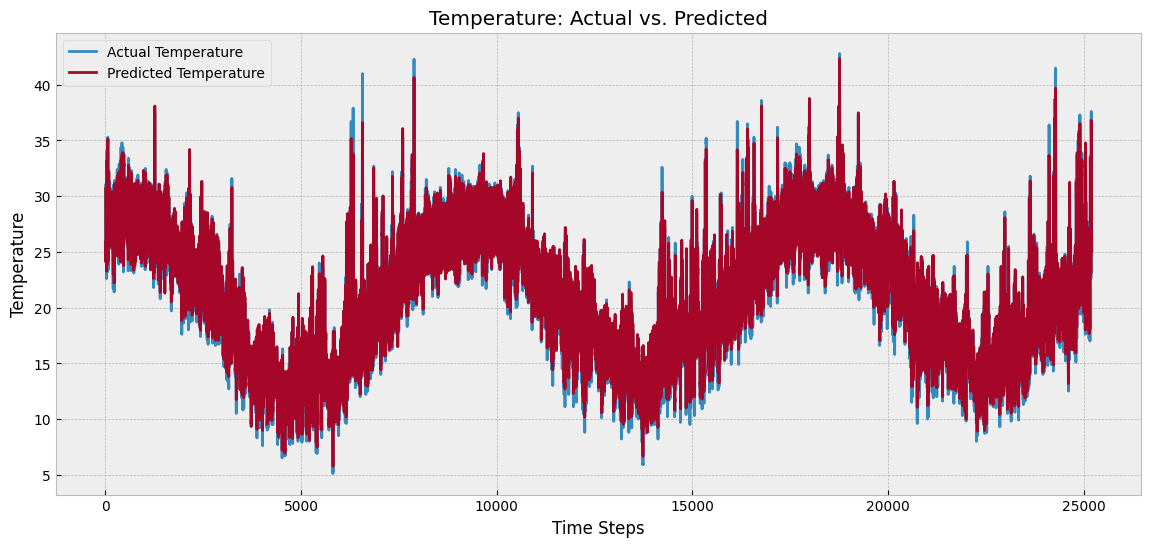

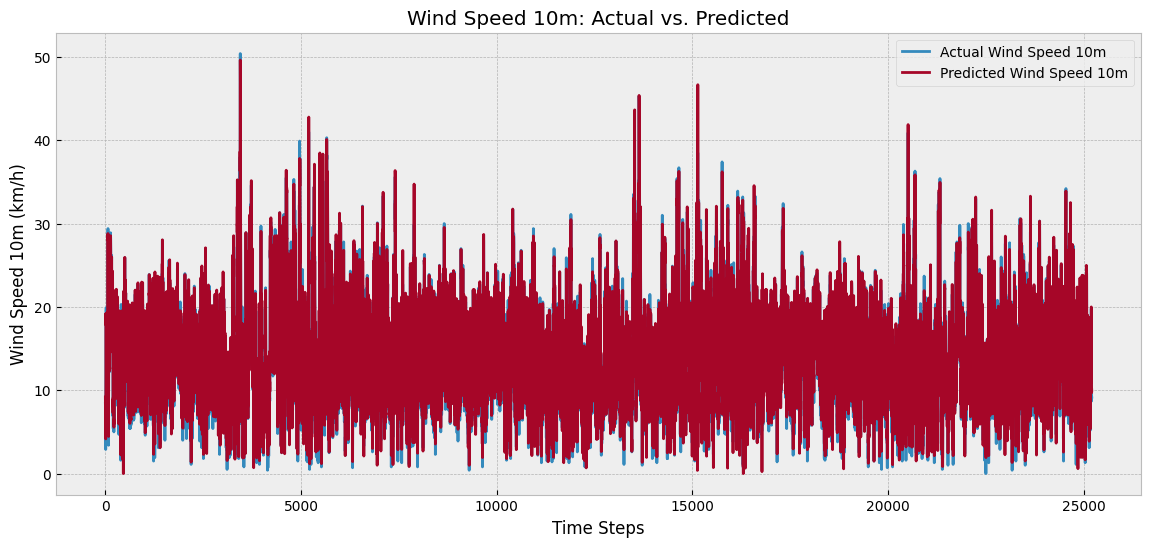

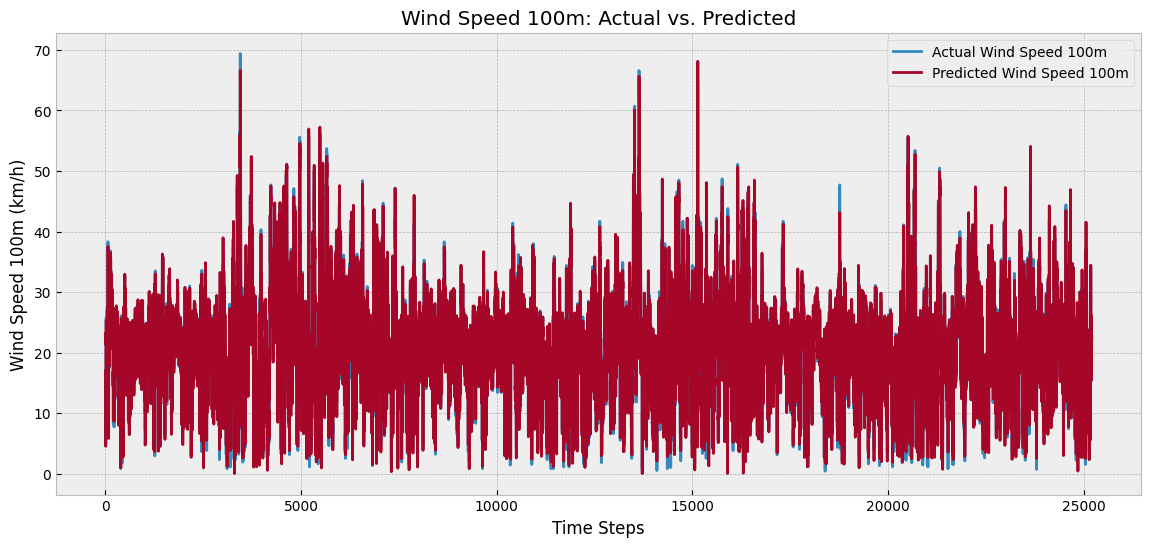

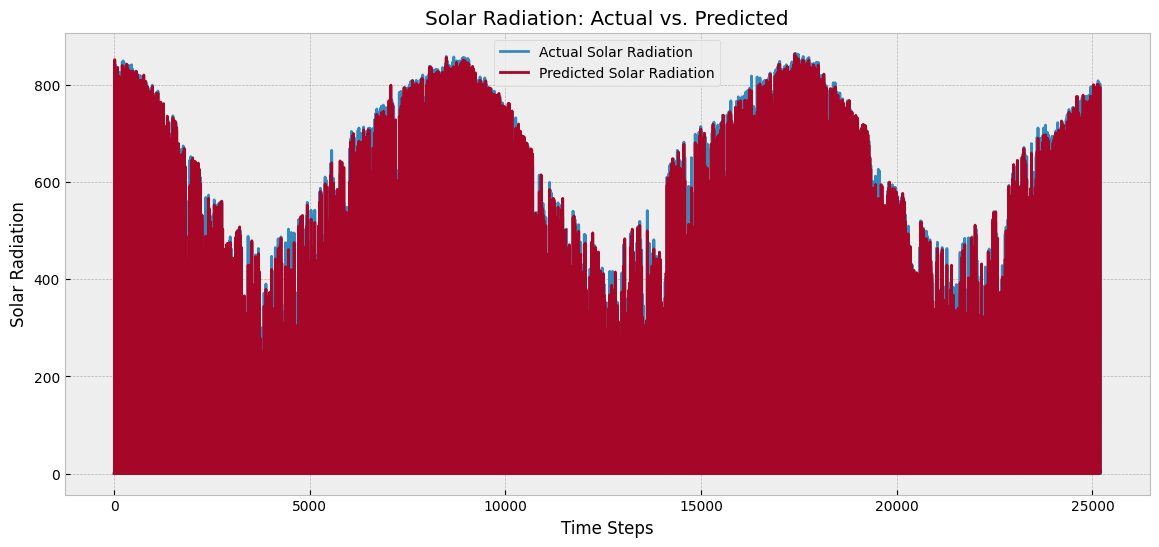

In [40]:

# Plot predictions vs. actual values for Temperature
plt.figure(figsize=(14, 6))
plt.plot(actual_values[:, 0], label='Actual Temperature')
plt.plot(predicted_values[:, 0], label='Predicted Temperature')
plt.title('Temperature: Actual vs. Predicted')
plt.xlabel('Time Steps')
plt.ylabel('Temperature')
plt.legend()
plt.show()

# Plot predictions vs. actual values for Wind Speed 10m
plt.figure(figsize=(14, 6))
plt.plot(actual_values[:, 1], label='Actual Wind Speed 10m')
plt.plot(predicted_values[:, 1], label='Predicted Wind Speed 10m')
plt.title('Wind Speed 10m: Actual vs. Predicted')
plt.xlabel('Time Steps')
plt.ylabel('Wind Speed 10m (km/h)')
plt.legend()
plt.show()

# Plot predictions vs. actual values for Wind Speed 100m
plt.figure(figsize=(14, 6))
plt.plot(actual_values[:, 2], label='Actual Wind Speed 100m')
plt.plot(predicted_values[:, 2], label='Predicted Wind Speed 100m')
plt.title('Wind Speed 100m: Actual vs. Predicted')
plt.xlabel('Time Steps')
plt.ylabel('Wind Speed 100m (km/h)')
plt.legend()
plt.show()

# Plot predictions vs. actual values for Solar Radiation
plt.figure(figsize=(14, 6))
plt.plot(actual_values[:, 3], label='Actual Solar Radiation')
plt.plot(predicted_values[:, 3], label='Predicted Solar Radiation')
plt.title('Solar Radiation: Actual vs. Predicted')
plt.xlabel('Time Steps')
plt.ylabel('Solar Radiation')
plt.legend()
plt.show()

In [41]:
# Create directory to save models
import os
if not os.path.exists('models'):
    os.makedirs('models')

# Save the model
model.save('models/final_model.h5')

# Save the model architecture to JSON
model_json = model.to_json()
with open("models/final_model.json", "w") as json_file:
    json_file.write(model_json)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# 5. **Final Training and Saving the Model**:
   - Train the model on the entire dataset.
   - Save the trained model in a folder named `models`.

# 6. **Load the trained model**

In [42]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

def read_data(data_path):
    # Read the dataset
    df = pd.read_csv(data_path)

    # Rename features for consistency
    renamed_features = {
        'Date ': 'date',
        'Ambient Temperature': 'ambient_temperature',
        'wind_speed_10m (km/h)': 'wind_speed_10m_kmh',
        'wind_speed_100m (km/h)': 'wind_speed_100m_kmh',
        'Solar Radiation': 'solar_radiation'
    }
    df.rename(columns=renamed_features, inplace=True)

    # Drop rows with missing values
    df.dropna(axis=0, inplace=True)

    # Convert date to datetime and set it as the index
    df['date'] = pd.to_datetime(df['date'])
    df.set_index('date', inplace=True)

    # Convert the dataset into numpy array
    data = np.array(df)

    # Scale the dataset
    scaler = MinMaxScaler()
    data = scaler.fit_transform(data)

    # Debugging: Check the scaled data
    print("Scaled data:")
    print(data[:5])

    return data, scaler, df.index

def create_sequences(data, sequence_length):
    X = []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length])

    # Debugging: Print the shape of the sequences
    print(f"Created sequences with shape: {np.array(X).shape}")

    return np.array(X)

def generate_future_predictions(model, initial_sequence, num_predictions):
    predictions = []
    current_sequence = initial_sequence

    for _ in range(num_predictions):
        prediction = model.predict(current_sequence[np.newaxis, :, :])
        predictions.append(prediction.flatten())
        current_sequence = np.append(current_sequence[1:], prediction, axis=0)

    # Debugging: Print the shape and first few predictions
    print(f"Generated predictions with shape: {np.array(predictions).shape}")
    print(f"First few predictions: {predictions[:5]}")

    return np.array(predictions)

def generate_future_dates(last_date, num_days):
    return pd.date_range(start=last_date, periods=num_days + 1, inclusive='right')


# Main script
import numpy as np
import pandas as pd
from tensorflow.keras.models import load_model
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Load original data and scaler
data_path = 'data/Alexandria - Weather Data.csv'
data, scaler, dates = read_data(data_path)

sequence_length = 24*3
X = create_sequences(data, sequence_length)

# Load the saved model
model = load_model('models/final_model.h5')

# Generate predictions for the next X*24 days where X is the number of days
initial_sequence = data[-sequence_length:]

# Debugging: Print initial sequence
print("Initial sequence for predictions:\n", initial_sequence)

num_predictions = 24*3*150
future_predictions = generate_future_predictions(model, initial_sequence, num_predictions)
future_predictions = scaler.inverse_transform(future_predictions)


Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 31ms/step
Generated predictions with shape: (10800, 4)
First few predictions: [array([0.5398135 , 0.17933547, 0.28372452, 0.00627148], dtype=float32), array([0.5318266 , 0.18412045, 0.2821297 , 0.01375486], dtype=float32), array([0.52780783, 0.18781221, 0.2774657 , 0.0266395 ], dtype=float32), array([0.5303101, 0.1917648, 0.2691136, 0.0524288], dtype=float32), array([0.55326724, 0.20334083, 0.25508684, 0.12758304], dtype=float32)]


<ipython-input-46-f4a66b5fb98b>:26: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


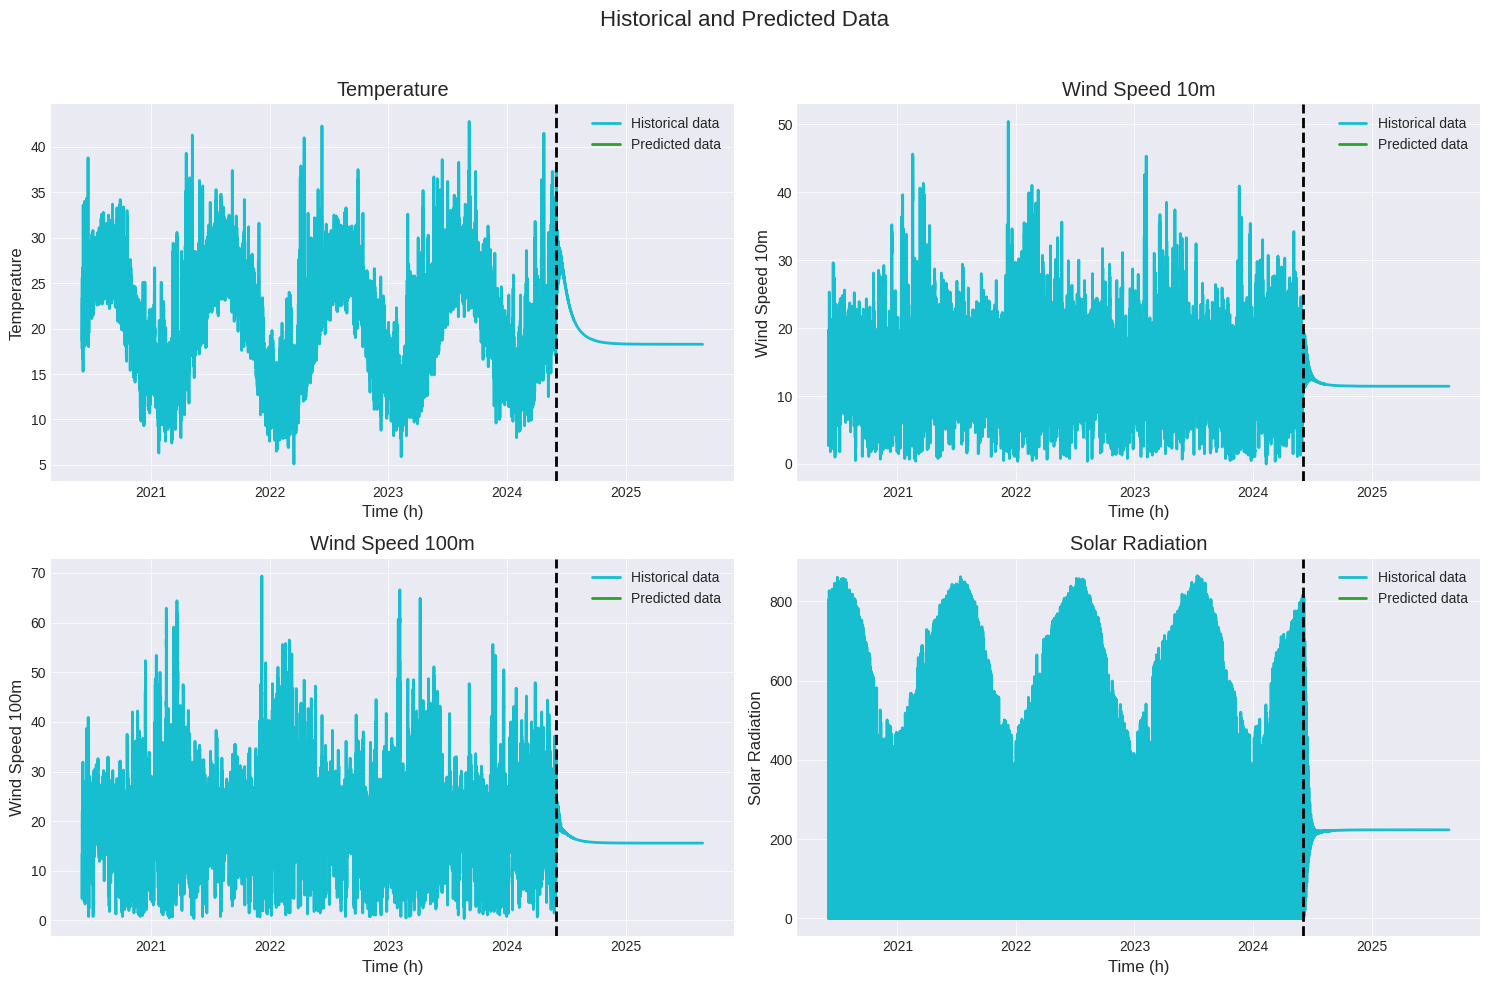

In [46]:
future_predictions = np.clip(future_predictions, a_min=0, a_max=None)

# Generate future dates
last_date = dates[-1]
future_dates = pd.date_range(start=last_date, periods=num_predictions, freq='H')

# Combine original and predicted data
historical_data = scaler.inverse_transform(data)  # Inverse transform historical data
all_dates = np.concatenate([dates, future_dates])
combined_data = np.concatenate([historical_data, future_predictions])

# Create DataFrame for combined data
df_combined = pd.DataFrame(
    combined_data,
    columns=['Temperature', 'Wind Speed 10m', 'Wind Speed 100m', 'Solar Radiation'],
    index=all_dates
)

# Save the new predictions with dates
df_combined.to_csv('results/predictions.csv', index=False)

# Adjust to focus on the last four years of historical data
focus_start_date = df_combined.index[-num_predictions - 4*365*24]

# Plot settings
plt.style.use('seaborn-darkgrid')
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
fig.suptitle('Historical and Predicted Data', fontsize=16)

# Plot each feature
features = ['Temperature', 'Wind Speed 10m', 'Wind Speed 100m', 'Solar Radiation']
colors = ['#17becf', '#2ca02c']  # Colors for historical and predicted data

for ax, feature in zip(axes.flatten(), features):
    # Plot historical data
    ax.plot(df_combined.loc[focus_start_date:].index[:len(historical_data)], df_combined.loc[focus_start_date:][feature][:len(historical_data)], color=colors[0], label='Historical data')

    # Plot predicted data
    ax.plot(df_combined.loc[focus_start_date:].index[len(historical_data):], df_combined.loc[focus_start_date:][feature][len(historical_data):], color=colors[1], label='Predicted data')

    # Highlight the transition point with a vertical line
    ax.axvline(x=df_combined.index[len(historical_data)], color='black', linestyle='--')

    # Set the title and labels
    ax.set_title(feature)
    ax.set_xlabel('Time (h)')
    ax.set_ylabel(feature)

    # Add a legend
    ax.legend()

# Adjust layout and show the plot
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
import optuna
from optuna.integration import TFKerasPruningCallback
from sklearn.metrics import mean_squared_error

tf.random.set_seed(42)  # Fix random seed for reproducibility.

# Function to create sequences
def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length])
        y.append(data[i+sequence_length])
    return np.array(X), np.array(y)

# Function to build the model
def build_model(input_shape, lstm_units=150, dropout_rate=0.1, bidirectional=True):
    model = Sequential()
    if bidirectional:
        model.add(Bidirectional(LSTM(lstm_units, return_sequences=True), input_shape=input_shape))
    else:
        model.add(LSTM(lstm_units, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(dropout_rate))
    if bidirectional:
        model.add(Bidirectional(LSTM(lstm_units, return_sequences=False)))
    else:
        model.add(LSTM(lstm_units, return_sequences=False))
    model.add(Dropout(dropout_rate))
    model.add(Dense(4))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Optuna objective function
def objective(trial):
    # Read the dataset
    df = pd.read_csv('data/Alexandria - Weather Data.csv')

    # Rename features for consistency
    renamed_features = {
        'Date ': 'date',
        'Ambient Temperature': 'ambient_temperature',
        'wind_speed_10m (km/h)': 'wind_speed_10m_kmh',
        'wind_speed_100m (km/h)': 'wind_speed_100m_kmh',
        'Solar Radiation': 'solar_radiation'
    }
    df.rename(columns=renamed_features, inplace=True)
    df.dropna(axis=0, inplace=True)

    # Convert date to datetime and set it as the index
    df['date'] = pd.to_datetime(df['date'])
    df.set_index('date', inplace=True)

    # Convert the dataset into numpy array
    data = np.array(df)

    # Hyperparameters to tune
    sequence_length = trial.suggest_int('sequence_length', 24, 24*7)
    lstm_units = trial.suggest_int('lstm_units', 50, 200)
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)
    bidirectional = trial.suggest_categorical('bidirectional', [True, False])
    scaler_type = trial.suggest_categorical('scaler', ['MinMaxScaler', 'StandardScaler', 'RobustScaler'])

    if scaler_type == 'MinMaxScaler':
        scaler = MinMaxScaler()
    elif scaler_type == 'StandardScaler':
        scaler = StandardScaler()
    else:
        scaler = RobustScaler()

    scaled_data = scaler.fit_transform(data)

    # Use 20% of the data for the Optuna optimization
    subset_size = int(len(df) * 0.2)
    subset_data = scaled_data[:subset_size]

    # Split into training and testing data
    train_size = int(len(subset_data) * 0.8)
    train_data, test_data = subset_data[:train_size], subset_data[train_size:]

    # Create sequences
    X_train, y_train = create_sequences(train_data, sequence_length)
    X_test, y_test = create_sequences(test_data, sequence_length)

    # Build and train the model
    model = build_model((sequence_length, 4), lstm_units, dropout_rate, bidirectional)
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    history = model.fit(X_train, y_train, epochs=50, batch_size=512*2*2,
                        validation_split=0.2, verbose=0,
                        callbacks=[early_stopping, TFKerasPruningCallback(trial, 'val_loss')])

    # Evaluate the model
    loss = model.evaluate(X_test, y_test, verbose=0)
    return loss

# Create an Optuna study and optimize the objective function
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

# Best hyperparameters
best_params = study.best_params
print(f'Best hyperparameters: {best_params}')

# Retrain the model with the best hyperparameters on the entire dataset
sequence_length = best_params['sequence_length']
lstm_units = best_params['lstm_units']
dropout_rate = best_params['dropout_rate']
bidirectional = best_params['bidirectional']

if best_params['scaler'] == 'MinMaxScaler':
    scaler = MinMaxScaler()
elif best_params['scaler'] == 'StandardScaler':
    scaler = StandardScaler()
else:
    scaler = RobustScaler()

scaled_data = scaler.fit_transform(data)

# Split into training and testing data
train_size = int(len(df) * 0.8)
train_data, test_data = scaled_data[:train_size], scaled_data[train_size:]

# Create sequences
X_train, y_train = create_sequences(train_data, sequence_length)
X_test, y_test = create_sequences(test_data, sequence_length)

# Build and train the model
model = build_model((sequence_length, 4), lstm_units, dropout_rate, bidirectional)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=100, batch_size=512*2*2,
                    validation_split=0.2, verbose=1, callbacks=[early_stopping])

# Evaluate the model
loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss:.4f}')
print('RMSE: ', np.sqrt(loss))

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Loss', 'Validation Loss'])
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

# Make predictions
predictions = model.predict(X_test)

# Inverse scale the predictions
predicted_values = scaler.inverse_transform(predictions)
actual_values = scaler.inverse_transform(y_test)

# Clip negative values to zero
predicted_values = np.clip(predicted_values, a_min=0, a_max=None)

# Compare predictions with actual values
comparison = pd.DataFrame({
    'Actual Temperature': actual_values[:, 0],
    'Predicted Temperature': predicted_values[:, 0],
    'Actual Wind Speed 10m': actual_values[:, 1],
    'Predicted Wind Speed 10m': predicted_values[:, 1],
    'Actual Wind Speed 100m': actual_values[:, 2],
    'Predicted Wind Speed 100m': predicted_values[:, 2],
    'Actual Solar Radiation': actual_values[:, 3],
    'Predicted Solar Radiation': predicted_values[:, 3],
})

# Final predictions for the next 15 days
def generate_future_predictions(model, initial_sequence, num_predictions):
    predictions = []
    current_sequence = initial_sequence

    for _ in range(num_predictions):
        prediction = model.predict(current_sequence[np.newaxis, :, :])
        predictions.append(prediction.flatten())
        current_sequence = np.append(current_sequence[1:], prediction, axis=0)

    return np.array(predictions)

# Generate predictions for the next 15*24 hours (15 days)
initial_sequence = data[-sequence_length:]
num_predictions = 15 * 24
future_predictions = generate_future_predictions(model, initial_sequence, num_predictions)
future_predictions = scaler.inverse_transform(future_predictions)
future_predictions = np.clip(future_predictions, a_min=0, a_max=None)

# Generate future dates
last_date = df.index[-1]
future_dates = pd.date_range(start=last_date, periods=num_predictions, freq='H')

# Combine original and predicted data
historical_data = scaler.inverse_transform(data)  # Inverse transform historical data
all_dates = np.concatenate([df.index, future_dates])
combined_data = np.concatenate([historical_data, future_predictions])

# Create DataFrame for combined data
df_combined = pd.DataFrame(
    combined_data,
    columns=['Temperature', 'Wind Speed 10m', 'Wind Speed 100m', 'Solar Radiation'],
    index=all_dates
)

# Adjust to focus on the last four years of historical data
focus_start_date = df_combined.index[-num_predictions - 4*365*24]

# Plot settings
plt.style.use('seaborn-darkgrid')
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
fig.suptitle('Historical and Predicted Data', fontsize=16)

# Plot each feature
features = ['Temperature', 'Wind Speed 10m', 'Wind Speed 100m', 'Solar Radiation']
colors = ['#17becf', '#2ca02c']  # Colors for historical and predicted data

for ax, feature in zip(axes.flatten(), features):
    # Plot historical data
    ax.plot(df_combined.loc[focus_start_date:].index[:len(historical_data)], df_combined.loc[focus_start_date:][feature][:len(historical_data)], color=colors[0], label='Historical data')

    # Plot predicted data
    ax.plot(df_combined.loc[focus_start_date:].index[len(historical_data):], df_combined.loc[focus_start_date:][feature][len(historical_data):], color=colors[1], label='Predicted data')

    # Highlight the transition point with a vertical line
    ax.axvline(x=df_combined.index[len(historical_data)], color='black', linestyle='--')

    # Set the title and labels
    ax.set_title(feature)
    ax.set_xlabel('Time (h)')
    ax.set_ylabel(feature)

    # Add a legend
    ax.legend()

# Adjust layout and show the plot
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


[I 2024-06-08 18:05:38,651] A new study created in memory with name: no-name-c6d476ca-3a29-4397-8f16-76b4a1a8d495
[I 2024-06-08 18:05:57,561] Trial 0 finished with value: 0.013616921380162239 and parameters: {'sequence_length': 68, 'lstm_units': 88, 'dropout_rate': 0.2993105202326772, 'bidirectional': False, 'scaler': 'RobustScaler'}. Best is trial 0 with value: 0.013616921380162239.
[I 2024-06-08 18:07:21,830] Trial 1 finished with value: 0.018379690125584602 and parameters: {'sequence_length': 115, 'lstm_units': 131, 'dropout_rate': 0.29795496010094286, 'bidirectional': True, 'scaler': 'StandardScaler'}. Best is trial 0 with value: 0.013616921380162239.
[I 2024-06-08 18:07:43,786] Trial 2 finished with value: 0.014199403114616871 and parameters: {'sequence_length': 68, 'lstm_units': 116, 'dropout_rate': 0.41626181197737433, 'bidirectional': False, 'scaler': 'RobustScaler'}. Best is trial 0 with value: 0.013616921380162239.
[I 2024-06-08 18:08:20,342] Trial 3 finished with value: 0.02

Best hyperparameters: {'sequence_length': 122, 'lstm_units': 191, 'dropout_rate': 0.1170230619771926, 'bidirectional': True, 'scaler': 'MinMaxScaler'}


NameError: name 'data' is not defined

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler

tf.random.set_seed(42)  # Fix random seed for reproducibility.

# Function to create sequences
def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i + sequence_length])
        y.append(data[i + sequence_length])
    return np.array(X), np.array(y)

# Function to build the model
def build_model(input_shape, lstm_units=150, dropout_rate=0.1, bidirectional=True):
    model = Sequential()
    if bidirectional:
        model.add(Bidirectional(LSTM(lstm_units, return_sequences=True), input_shape=input_shape))
    else:
        model.add(LSTM(lstm_units, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(dropout_rate))
    if bidirectional:
        model.add(Bidirectional(LSTM(lstm_units, return_sequences=False)))
    else:
        model.add(LSTM(lstm_units, return_sequences=False))
    model.add(Dropout(dropout_rate))
    model.add(Dense(4))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Read the dataset
df = pd.read_csv('data/Alexandria - Weather Data.csv')

# Rename features for consistency
renamed_features = {
    'Date ': 'date',
    'Ambient Temperature': 'ambient_temperature',
    'wind_speed_10m (km/h)': 'wind_speed_10m_kmh',
    'wind_speed_100m (km/h)': 'wind_speed_100m_kmh',
    'Solar Radiation': 'solar_radiation'
}
df.rename(columns=renamed_features, inplace=True)
df.dropna(axis=0, inplace=True)

# Convert date to datetime and set it as the index
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

# Convert the dataset into numpy array
data = np.array(df)

# Best hyperparameters from Optuna
best_params = {
    'sequence_length': 122,
    'lstm_units': 191,
    'dropout_rate': 0.1170230619771926,
    'bidirectional': True,
    'scaler': 'MinMaxScaler'
}

if best_params['scaler'] == 'MinMaxScaler':
    scaler = MinMaxScaler()

scaled_data = scaler.fit_transform(data)

# Split into training and testing data
train_size = int(len(df) * 0.8)
train_data, test_data = scaled_data[:train_size], scaled_data[train_size:]

# Create sequences
X_train, y_train = create_sequences(train_data, best_params['sequence_length'])
X_test, y_test = create_sequences(test_data, best_params['sequence_length'])

model = build_model((best_params['sequence_length'], 4),
                    best_params['lstm_units'],
                    best_params['dropout_rate'],
                    best_params['bidirectional'])

# Add EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=100, batch_size=512*4,
                    validation_split=0.2, verbose=1, callbacks=[early_stopping])

# Evaluate the model
loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss:.4f}')
print('RMSE: ', np.sqrt(loss))

# Save the model
model.save('models/final_model.h5')


Epoch 1/100
38/38 [==============================] - 19s 322ms/step - loss: 0.0344 - val_loss: 0.0137
Epoch 2/100
38/38 [==============================] - 11s 280ms/step - loss: 0.0099 - val_loss: 0.0070
Epoch 3/100
38/38 [==============================] - 11s 282ms/step - loss: 0.0063 - val_loss: 0.0055
Epoch 4/100
38/38 [==============================] - 11s 282ms/step - loss: 0.0051 - val_loss: 0.0046
Epoch 5/100
38/38 [==============================] - 11s 283ms/step - loss: 0.0044 - val_loss: 0.0042
Epoch 6/100
38/38 [==============================] - 11s 284ms/step - loss: 0.0040 - val_loss: 0.0038
Epoch 7/100
38/38 [==============================] - 11s 285ms/step - loss: 0.0038 - val_loss: 0.0039
Epoch 8/100
38/38 [==============================] - 11s 285ms/step - loss: 0.0036 - val_loss: 0.0036
Epoch 9/100
38/38 [==============================] - 11s 286ms/step - loss: 0.0033 - val_loss: 0.0035
Epoch 10/100
38/38 [==============================] - 11s 286ms/step - loss: 0.003

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 25ms/step


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler

# Assuming 'df' is your original DataFrame and 'scaler' is your MinMaxScaler instance
# Ensure df and scaler are defined and properly loaded

# Load the saved model
model = keras.models.load_model('models/final_model.h5')

# Generate predictions for the next 3*122 hours (based on the sequence length)
initial_sequence = scaled_data[-best_params['sequence_length']:]

def generate_future_predictions(model, initial_sequence, num_predictions):
    predictions = []
    current_sequence = initial_sequence

    for _ in range(num_predictions):
        prediction = model.predict(current_sequence[np.newaxis, :, :])
        predictions.append(prediction.flatten())
        current_sequence = np.append(current_sequence[1:], prediction, axis=0)

    return np.array(predictions)

num_predictions = 122 * 3 * 10
future_predictions = generate_future_predictions(model, initial_sequence, num_predictions)
future_predictions = scaler.inverse_transform(future_predictions)

# Clip negative values to zero
future_predictions = np.clip(future_predictions, a_min=0, a_max=None)



In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler

# Assuming 'df' is your original DataFrame and 'scaler' is your MinMaxScaler instance
# Ensure df and scaler are defined and properly loaded

# Load the saved model
model = keras.models.load_model('models/final_model.h5')

# Generate predictions for the next 3*122 hours (based on the sequence length)
sequence_length = 122
initial_sequence = scaled_data[-sequence_length:]

def generate_future_predictions(model, initial_sequence, num_predictions):
    predictions = []
    current_sequence = initial_sequence

    for _ in range(num_predictions):
        prediction = model.predict(current_sequence[np.newaxis, :, :])
        predictions.append(prediction.flatten())
        current_sequence = np.append(current_sequence[1:], prediction, axis=0)

    return np.array(predictions)

num_predictions = 122 * 3 * 100
future_predictions = generate_future_predictions(model, initial_sequence, num_predictions)
future_predictions = scaler.inverse_transform(future_predictions)

# Clip negative values to zero
future_predictions = np.clip(future_predictions, a_min=0, a_max=None)

# Combine original and predicted data
historical_data = scaler.inverse_transform(scaled_data)  # Inverse transform historical data
all_dates = np.concatenate([df.index, pd.date_range(start=df.index[-1], periods=num_predictions, freq='H')])
combined_data = np.concatenate([historical_data, future_predictions])

# Create DataFrame for combined data
df_combined = pd.DataFrame(
    combined_data,
    columns=['Temperature', 'Wind Speed 10m', 'Wind Speed 100m', 'Solar Radiation'],
    index=all_dates
)

# Save the new predictions with dates
df_combined.to_csv('results/predictions.csv', index=False)

# Calculate the focus start date for the last four years
focus_start_date = df_combined.index[-(num_predictions + 4*365*24)]

# Slice the DataFrame to focus on the last four years and forecasted data
df_focus = df_combined[focus_start_date:]

# Ensure plotting within Jupyter Notebook
%matplotlib inline

# Use seaborn style
sns.set(style='darkgrid')

# Plot settings
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
fig.suptitle('Historical and Predicted Data', fontsize=16)

# Plot each feature
features = ['Temperature', 'Wind Speed 10m', 'Wind Speed 100m', 'Solar Radiation']
colors = ['#17becf', '#2ca02c']  # Colors for historical and predicted data

for ax, feature in zip(axes.flatten(), features):
    # Plot historical data
    ax.plot(df_focus.index[:len(df_focus) - num_predictions], df_focus[feature][:len(df_focus) - num_predictions], color=colors[0], label='Historical data')

    # Plot predicted data
    predicted_start_idx = len(df_focus) - num_predictions
    ax.plot(df_focus.index[predicted_start_idx:], df_focus[feature][predicted_start_idx:], color=colors[1], label='Predicted data')

    # Highlight the transition point with a vertical line
    ax.axvline(x=df_focus.index[predicted_start_idx], color='black', linestyle='--')

    # Set the title and labels
    ax.set_title(feature)
    ax.set_xlabel('Time (h)')
    ax.set_ylabel(feature)

    # Add a legend
    ax.legend()

# Adjust layout and show the plot
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 30ms/step


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-19-e312b57c8519>", line 30, in <cell line: 30>
    future_predictions = generate_future_predictions(model, initial_sequence, num_predictions)
  File "<ipython-input-19-e312b57c8519>", line 23, in generate_future_predictions
    prediction = model.predict(current_sequence[np.newaxis, :, :])
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2620, in predict
    data_handler = data_adapter.get_data_handler(
  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/data_adapter.py", line 1688, in get_data_handler
    return DataHandler(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packa

TypeError: object of type 'NoneType' has no len()

In [26]:
!git add models

In [27]:
!git commit -m "uploading from colab"

Author identity unknown

*** Please tell me who you are.

Run

  git config --global user.email "you@example.com"
  git config --global user.name "Your Name"

to set your account's default identity.
Omit --global to set the identity only in this repository.

fatal: unable to auto-detect email address (got 'root@feb7ff33c8b1.(none)')


In [25]:
!git status

On branch main
Your branch is up to date with 'origin/main'.

Changes to be committed:
  (use "git restore --staged <file>..." to unstage)
	modified:   models/final_model.h5

Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git restore <file>..." to discard changes in working directory)
	modified:   data/Alexandria - Weather Data.csv

Untracked files:
  (use "git add <file>..." to include in what will be committed)
	results/

